In [52]:
import pandas as pd
import numpy as np
import lifelines

In [2]:
datafile = "HR_dataset.csv"
data = pd.read_csv(datafile)

### Exploratory Data Analysis

In [3]:
display(data.head())
print(data.columns)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')


### Survival Analysis
Here, we are interested in seeing how the YearsAtCompany vs Attrition

In [4]:
def create_life_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function takes a dataframe with the number of year at the company and wether the person have left the company of not
    """
    
    df = df[["YearsAtCompany","Attrition"]]
    life_table = df.groupby("YearsAtCompany").count().rename(columns={"Attrition": "Population"})
    life_table["AttritionNum"] = df.groupby("YearsAtCompany")["Attrition"].apply(lambda x: (x=='Yes').sum())
    life_table["AttritionRate"] = life_table["AttritionNum"]/life_table["Population"]

    ### If you reach year n, what is the probability you will leave before n+1
    ### Here we make an assumption that the attition happens uniformly between day 1 to day 364 in a given year
    ### due to a lack of information
    life_table["ConditionalProbAttrition"] = life_table["AttritionNum"]/(life_table["Population"]+0.5*life_table["AttritionNum"])
    life_table["ConditionalProbNoAttrition"] = 1 - life_table["ConditionalProbAttrition"]

    ### Here we assume a baseline number  of population to be 100,000 so the caculation is made easier
    attrition_list = []
    for index, row in life_table.iterrows():
        if index != 0 :
            attrition_list.append(pervious_rate*pervious_pop)
            pervious_rate = row["ConditionalProbNoAttrition"]
        else:
            attrition_list.append(100000)
        pervious_rate = row["ConditionalProbNoAttrition"]
        pervious_pop = attrition_list[-1]
    life_table["AttritionNumToYear"] = attrition_list

    life_table["ProportionToYear"] = life_table["AttritionNumToYear"]/100000

    num_to_year = list(life_table["AttritionNumToYear"].values)
    num_to_year_plus1 = num_to_year[1:] + [0]
    life_table["EmployeeYearAtYear"] = (np.array(num_to_year)+np.array(num_to_year_plus1))/2

    total_year_at0 = sum(life_table["EmployeeYearAtYear"].values)
    total_year_list = [total_year_at0]

    for value in life_table["EmployeeYearAtYear"].values[:-1]:
        total_year_list.append(total_year_list[-1] - value)

    life_table["TotalYearEmployFromYear"] = total_year_list

    life_table["TotalEmploymentExpectancy"] = life_table["TotalYearEmployFromYear"]/100000

    ### Evaulate employment terms with "Outstanding" performance rating

    performance_rating = data[["YearsAtCompany","PerformanceRating"]]

    life_table["ProportionWithExcellent"] = performance_rating.groupby("YearsAtCompany")["PerformanceRating"].apply(list).apply(lambda x: x.count(4)/len(x))

    life_table["TotalEmpYearWithExcellent"] = life_table["EmployeeYearAtYear"]*life_table["ProportionWithExcellent"]

    total_excellent_at0 = sum(life_table["TotalEmpYearWithExcellent"].values)
    total_year_list = [total_excellent_at0]
    for value in life_table["TotalEmpYearWithExcellent"].values[:-1]:
        total_year_list.append(total_year_list[-1] - value)

    life_table["TotalYearExcellentFromYear"] = total_year_list

    life_table["ExcellentExpectancy"] = life_table["TotalYearExcellentFromYear"] /100000

    life_table["RemainInEmployment"] = (life_table["Population"]-life_table["AttritionNum"])/life_table["Population"]

    return life_table

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

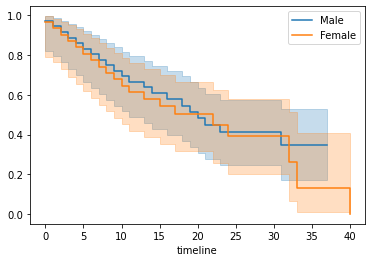

In [6]:
DataFrameDict = {elem : pd.DataFrame() for elem in data["Gender"].unique()}
for key in DataFrameDict.keys():
    DataFrameDict[key] = data[:][data["Gender"] == key]

male_table = create_life_table(DataFrameDict['Male'])
female_table = create_life_table(DataFrameDict['Female'])

from lifelines import KaplanMeierFitter
kmf_male = KaplanMeierFitter() 
kmf_male.fit(male_table.index, male_table.AttritionNum,label='Male')
ax = kmf_male.plot()

kmf_female = KaplanMeierFitter()
kmf_female.fit(female_table.index, female_table.AttritionNum, label="Female")
ax = kmf_female.plot(ax=ax)

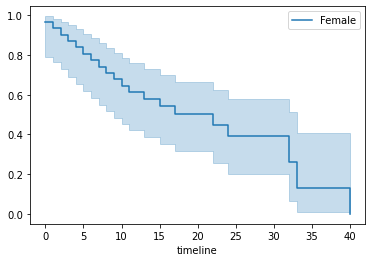

In [29]:
kmf_female = KaplanMeierFitter()
kmf_female.fit(female_table.index, female_table.AttritionNum, label="Female")
ax = kmf_female.plot()

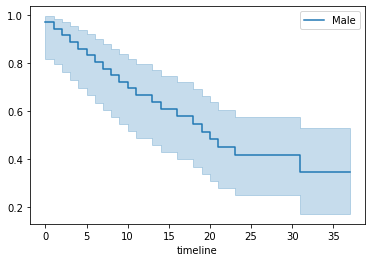

In [25]:
kmf_male = KaplanMeierFitter() 
kmf_male.fit(male_table.index, male_table.AttritionNum,label='Male')
ax = kmf_male.plot()

In [7]:
DataFrameDict = {elem : pd.DataFrame() for elem in data["JobSatisfaction"].unique()}


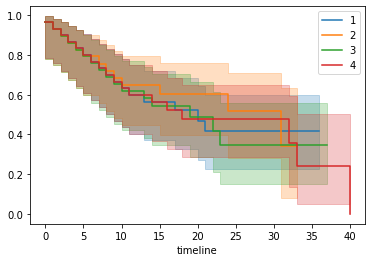

In [8]:
for key in DataFrameDict.keys():
    DataFrameDict[key] = data[:][data["JobSatisfaction"] == key]

table_1 = create_life_table(DataFrameDict[1])
table_2 = create_life_table(DataFrameDict[2])
table_3 = create_life_table(DataFrameDict[3])
table_4 = create_life_table(DataFrameDict[4])

from lifelines import KaplanMeierFitter
kmf_1 = KaplanMeierFitter() 
kmf_1.fit(table_1.index, table_1.AttritionNum,label='1')
ax = kmf_1.plot()

kmf_2 = KaplanMeierFitter()
kmf_2.fit(table_2.index, table_2.AttritionNum, label="2")
ax = kmf_2.plot(ax=ax)

kmf_3 = KaplanMeierFitter()
kmf_3.fit(table_3.index, table_3.AttritionNum, label="3")
ax = kmf_3.plot(ax=ax)

kmf_4 = KaplanMeierFitter()
kmf_4.fit(table_4.index, table_4.AttritionNum, label="4")
ax = kmf_4.plot(ax=ax)



In [9]:
DataFrameDict = {elem : pd.DataFrame() for elem in data["OverTime"].unique()}
for key in DataFrameDict.keys():
    DataFrameDict[key] = data[:][data["OverTime"] == key]


In [13]:
DataFrameDict["Yes"]

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
6,59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,...,1,80,3,12,3,2,1,0,0,0
11,29,No,Travel_Rarely,153,Research & Development,15,2,Life Sciences,1,15,...,4,80,0,10,3,3,9,5,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,35,No,Travel_Rarely,1146,Human Resources,26,4,Life Sciences,1,2040,...,3,80,0,9,2,3,9,0,1,7
1456,35,No,Travel_Frequently,1199,Research & Development,18,4,Life Sciences,1,2049,...,4,80,2,10,2,4,10,2,0,2
1459,29,No,Travel_Rarely,1378,Research & Development,13,2,Other,1,2053,...,1,80,1,10,2,3,4,3,0,3
1461,50,Yes,Travel_Rarely,410,Sales,28,3,Marketing,1,2055,...,2,80,1,20,3,3,3,2,2,0


(0.0, 1.0)

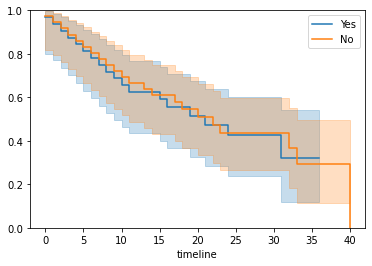

In [11]:

yes_table = create_life_table(DataFrameDict['Yes'])
no_table = create_life_table(DataFrameDict['No'])

from lifelines import KaplanMeierFitter
kmf_yes = KaplanMeierFitter() 
kmf_yes.fit(yes_table.index, yes_table.AttritionNum,label='Yes')
ax = kmf_yes.plot()

kmf_no = KaplanMeierFitter()
kmf_no.fit(no_table.index, no_table.AttritionNum, label="No")
ax = kmf_no.plot(ax=ax)
ax.set_ylim([0.0, 1.0])

(0.0, 1.0)

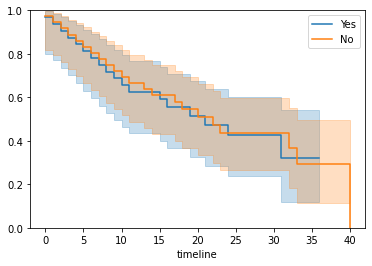

In [20]:

yes_table = create_life_table(DataFrameDict['Yes'])
no_table = create_life_table(DataFrameDict['No'])

from lifelines import KaplanMeierFitter
kmf_yes = KaplanMeierFitter() 
kmf_yes.fit(yes_table.index, yes_table.AttritionNum,label='Yes')
ax = kmf_yes.plot()

kmf_no = KaplanMeierFitter()
kmf_no.fit(no_table.index, no_table.AttritionNum, label="No")
ax = kmf_no.plot(ax=ax)
ax.set_ylim([0.0, 1.0])

In [58]:
T = data["YearsAtCompany"]
C = data["Attrition"].replace({"No":0,"Yes":1})

In [59]:
kmf = KaplanMeierFitter() 

In [60]:
kmf.fit(T,C)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1470 total observations, 1233 right-censored observations>

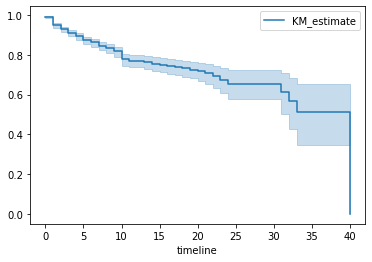

In [61]:
ax = kmf.plot()